# FIT5201_2018S2 Assignment 2 - Section A - Question 1

- <font color='blue'>**Student Id**</font>: 27771539
- <font color='blue'>**Student Name**</font>: Chuangfu Xie
- <font color='blue'>**Packages in use**</font>:
    - `tm`: for NLP

## 0. Import packages:

In [1]:
library(tm)

Loading required package: NLP


## 1. Derive Expectation and Maximisation steps of the hard-EM algorithm

Here we define a collection of documents as:
$$\pmb{D}:=\{\pmb{D}_1, \pmb{D}_2, \cdots, \pmb{D}_n\}$$
let assume that the real number of clusters equals to K, then we can give each document vector $z_{nk}$ indicating which cluster it should be assigned to:
$$\pmb{Z}:=\left(\pmb{Z}_{ 1 },\pmb{Z}_{ 2 },\cdots ,\pmb{Z}_{ n } \right) ^{ T }=\begin{vmatrix} z_{11} &z_{12} & \cdots & z_{1k} \\ z_{21} &z_{22} & \cdots & z_{2k} \\ \cdots & \cdots & \cdots & \cdots \\ z_{n1} &z_{n2} & \cdots & z_{nk} \end{vmatrix}$$

Note that by using 1-of-k scheme, only one element of the $\pmb{Z}_i$ is 1 and the rest are zeros.

Then we can define the likelihood:

$$p(\pmb{D}_{i},\pmb{Z}_{i}) = \prod_{k=1}^{K}{(\phi_{k}\prod_{w\in A}{\mu_{k,w}^{c(w,D_i)}})^{z_{nk}}}$$

Then, for the entire collection, we have define:

$$p(\pmb{D},\pmb{Z})=\prod_{n=1}^{N}{p(\pmb{D}_i,\pmb{Z}_i}) = \prod_{n=1}^{N}{\left[\prod_{k=1}^{K}{\left(\phi_{k}\prod_{w\in A}{\mu_{k,w}^{c(w,D_i)}}\right) ^{z_{nk}}}\right]}$$

Then, we can define the log likelihood:

$$\ln{p(\pmb{D},\pmb{Z})}=\sum_{n=1}^{N}{\ln\left[\sum_{k=1}^{K}{z_{nk}\cdot\left(\ln{\phi_{k}}+c(w,\pmb{D}_i)\cdot\ln{\mu_{k,w}}\right)}\right]}$$

However, since we do not know the $\pmb{Z}$, we can not use the join distribution to find the real clustering. The log likelihood will become:

$$\ln{p(\pmb{D})}=\sum_{n=1}^{N}{\ln\left[\sum_{k=1}^{K}{\left(\phi_{k}\prod_{w\in A}{\mu_{k,w}^{c(w,D_i)}}\right)}\right]}$$

However, the summation process is embebed in a logarithm. **Due to the the precent of singularity, we can not use MLE to find the optimal parameters. But we can use the posterior probability as heuristic to construct the cost function**.  
Therefore, we construct the Q function and resort to EM algorithm.

$$Q(\pmb{\theta},\pmb{\theta}^{old}):=\sum_{n=1}^{N}{\sum_{k=1}^{K}{p(z_{nk}|\pmb{D}_i,\pmb{\theta}^{old})\ln{p(z_{nk},\pmb{D}_i|\pmb{\theta})}}} \\ =\sum_{n=1}^{N}{\ln\left[\sum_{k=1}^{K}{\gamma_{z_{nk}}\cdot\left(\ln{\phi_{k}}+c(w,\pmb{D}_i)\cdot\ln{\pmb{\mu}_{k,w}}\right)}\right]}$$

Hence, we can process as follow:
## Soft assignment
1. preprocess the collection of documents, and get words count $c(w,\pmb{D}_i)$
2. Choose initial values for $\phi$(assume each cluster contains equal size of data), $\pmb{\mu}_{k,w}$ (randomly pick cluster centroid)
3. **Soft E-step**: Evaluate the posterior $\gamma_{z_{nk}}$
4. **M-step**: update the $\phi$ and $\pmb{\mu}_{k,w}$ by $\gamma_{z_{nk}}$
5. redo 2,3,4 until the convergence criterion is satisfied or has reached the maximum number of iterations.

## Hard assignment
1. preprocess the collection of documents, and get words count $c(w,\pmb{D}_i)$
2. Choose initial values for $\phi$(assume each cluster contains equal size of data), $\pmb{\mu}_{k,w}$ (randomly pick cluster centroid)
3. **Hard E-step**: Evaluate the posterior $\gamma_{z_{nk}}$. Then find the element in the assign vector having the maxmum posterior and assign 1 to it, and also assign 0 to the rest.
4. **M-step**: update the $\phi$ and $\pmb{\mu}_{k,w}$ by $\gamma_{z_{nk}}$
5. redo 2,3,4 until the convergence criterion is satisfied or has reached the maximum number of iterations.

## 2. Implement the hard-EM and the soft-EM

### 2.0 Auxilary function

In [2]:
initial.param <- function(size, K){
    # assume all clusters have the same size (we will update this later on)
    Phi <- matrix(1/K,nrow = K, ncol=1)
    
    # initiate Mu: randomly generate
    Mu <- matrix(runif(K*size), nrow = K, ncol = size)
    
    # normalization to ensure that sum of each row is 1
    Mu <- prop.table(Mu, margin = 1)
    
    # return Phi(prior) and initial Mu(centroid) of each clusters
    return (list("Phi" = Phi, "Mu"= Mu))
}

# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v){
    # Input:    logA1, logA2, ..., logAn
    # Output:   log(A1+A2+...+An)
    m = max(v)
    return (m + log(sum(exp(v-m))))
}

Q_func<- function(model, counts){
    # number of documents
    N <- dim(counts)[2]
    # number of clusters
    K <- dim(model$Mu)[1]
    
    Q <- 0
    for (n in 1:N){
        # for each document
        wc_mu_m <- matrix(0,ncol = 1, nrow=K)
        for (k in 1:K){
            # for each cluster
            wc_mu_m[k,1] = sum(counts[,n] * log(model$Mu[k,])) 
        }
        Q <- Q - logSum(log(model$Phi) + wc_mu_m)
    }
    return(Q)
}

### 2.1 Soft/Hard-E step:

In [3]:
E.step <- function(Post, model, counts, type=T){ 
    # Get dimensions 
    K <- dim(model$Mu)[1]
    # Get number of data
    N <- dim(counts)[2]

    for (n in 1:N){
        # for each data
        for (k in 1:K){
            # calculate the posterior based on the estimated mu and phi in the "log space"
            Post[n,k] <- log(model$Phi[k,1]) +  sum(counts[,n] * log(model$Mu[k,])) 
        }
        # normalisation to sum to 1 in the log space
        logZ = logSum(Post[n,])
        # update each data posterior
        Post[n,] = Post[n,] - logZ
    }
    # converting back from the log space 
    Post <- exp(Post)
    
    if (!type){
        index <- Post == apply(Post, 1, max)
        Post[index] <- 1
        Post[!index] <- 0
    }
    #return the new posterior(responsibility)
    return (Post)
}

### 2.3 M step:

In [4]:
M.step <- function(model, Post, counts){
    # Parameters
    D <- dim(counts)[1]   # vocabulary size
    N <- dim(counts)[2]   # number of documents
    
    K <- dim(model$Mu)[1] # number of clusters

    for (k in 1:K){
        # update prior
        model$Phi[k] <- sum(Post[,k])/N
        # update means (cenroids)
        model$Mu[k,] <- (Post[,k] %*%  t(counts)) / sum(Post[,k] %*%  t(counts))  
        }
    
    # Normalising:
    # Add a small number (eps) to all elements of the vector, then divide the elements by (a1+...+an+ 3*eps) so that the vecotr sums to 1. 
    # Prevents NaN for vectors where all elements are zero such that results in the uniform distribution after normalisation.  
    model$Mu <- scale(model$Mu+1e-10, center = F, scale=colSums(model$Mu+1e-10))

    # Return the result
    return(model)
}

### 2.4 EM Algorithm (with choices for soft/hard)

In [5]:
EM <- function(counts, K, eta.max=50, epsilon=0.01, type="soft", print_Q = FALSE){
    # Input:
    # counts: word counts
    # K: number of clusters
    # eta.max: maximum iteration, default 50
    # epsilon: threshold to stop the iteration, default 0.01
    # type: soft E-step or Hard E-step, default soft
    # Output:
    # A list of results: Mu，Post
    
    # Detect method in E step
    if (type == "soft") soft_E <- T else soft_E <- F
    
    # Get vocabulary size
    D <- dim(counts)[1]
    # Get the number of data
    N <- dim(counts)[2]
    
    # initalise parameters: Phi, Mu
    model <- initial.param(D,K)
    
    #initialise matrix for later posterior calculation
    Post <- matrix(0, nrow=N, ncol=K)
    
    # initialise eta counter and terminator
    eta <- 1
    terminate <- F
    
    while(!terminate){
        # E step
        # perform soft/hard E step base on the soft_E
        Post <- E.step(Post, model, counts, soft_E)
        
        # Store the old Mu
        Mu.old <- model$Mu
        
        # perform M step: Update Phi, Mu
        model <- M.step(model, Post, counts)
        
        # counter increments
        eta <- eta + 1
        
        # print objective function value
        if (print_Q){
            if (eta%%5 == 0){
                # every 5 iteration
                print(paste("@", eta, ": ", Q_func(model, counts)))
            }
        }
        
        # check the termination criteria
        cond1 <- (eta > eta.max)                    # check boundaries
        cond2 <- (sum(abs(Mu.old - model$Mu)) <= epsilon) # check threshold
        terminate <- cond1 | cond2
    }
    
    cat('The maximum number of iterations is:', eta, '\n')
    cat('The Q function value:', Q_func(model, counts), '\n')
    
    # plot the result
    
    return(list('Model'=model, "Post"=Post))
}

## 3. Loading text and text preprocessing

In [6]:
# from codebase
read.data <- function(path, spr.ratio= 0.90) {
    # INPUTS:
    # > path: name of the input .txt file
    # > spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
    # OUTPUTS:
    # > docs: the unlabled corpus (each row is a document)
    # > labels: the real cluster labels (will be used in visualization/validation and not for clustering)
    # > m: the count matrix (each rows and columns corresponds to words and documents, respectively)

    # Read the data from given path
    text <- readLines(path)
    # lables(the newsgroup names) '\t' documents
    docs <- strsplit(text, '\t') 

    # Store the labels for evaluation
    labels <- unlist(lapply(docs, function(x){x[1]}))

    # Store the unlabeled texts
    texts <- unlist(lapply(docs, function(x){x[2]}))
    indices <- c(1:length(texts))
    docs <- data.frame(doc_id = indices, text=texts) 

    # Create a corpus
    docs <- DataframeSource(docs)
    corp <- Corpus(docs)
    
    # Preprocessing:
    # remove stop words 
    corp <- tm_map(corp, removeWords, stopwords("english"))
    # remove pnctuation
    corp <- tm_map(corp, removePunctuation)
    # perform stemming
    corp <- tm_map(corp, stemDocument)
    # remove all numbers
    corp <- tm_map(corp, removeNumbers)
    # remove redundant spaces
    corp <- tm_map(corp, stripWhitespace)

    # Create a matrix which its rows are the documents and colomns are the words. 
    dtm <- DocumentTermMatrix(corp)
    # Reduce the sparcity of out dtm
    dtm <- removeSparseTerms(dtm, spr.ratio)
    # convert to a matrix
    m <- t(as.matrix(dtm)) # each row is a word, each columns is a document
    
    return (list("docs" = docs, "labels" = labels, "m" = m))
}

In [7]:
# Read data and perform preprocessing
data <- read.data('./datasets/Task2A.txt')
# extract outputs
docs <- data$docs
labels <- data$labels
counts <- data$m
# Take a look at the real labels 
#(not cheating :) just in case find the wrong K)
table(labels)

labels
      sci.crypt sci.electronics         sci.med       sci.space 
            595             591             594             593 

## 4. Principle Component Analysis (PCA)

### Using soft EM:

In [8]:
soft_result <- EM(counts, K=4, type = 'soft', print_Q=TRUE)

[1] "@ 5 :  115611.563721395"
[1] "@ 10 :  115582.849731262"
[1] "@ 15 :  115566.711451988"
[1] "@ 20 :  115572.484316943"
[1] "@ 25 :  115569.242350883"
[1] "@ 30 :  115566.765447191"
[1] "@ 35 :  115565.745215088"
[1] "@ 40 :  115565.070646208"
[1] "@ 45 :  115564.213931028"
[1] "@ 50 :  115563.766065992"
The maximum number of iterations is: 51 
The Q function value: 115563.7 


### Using hard EM:

In [9]:
hard_result <- EM(counts, K=4, type = 'hard', print_Q=TRUE)

[1] "@ 5 :  116682.448684376"
[1] "@ 10 :  115691.346326615"
[1] "@ 15 :  115708.766069052"
The maximum number of iterations is: 19 
The Q function value: 115710.9 


In [10]:
# For visualise result
cluster.viz <- function(counts, color.vector, title=' '){
    p.comp <- prcomp(counts, scale. = TRUE, center = TRUE)
    plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

In [11]:
count.scaled <- scale(counts+1e-10, center=F) #avoid missing values
soft.labels <- apply(soft_result$Post, 1, which.max)
hard.labels <- apply(hard_result$Post, 1, which.max)

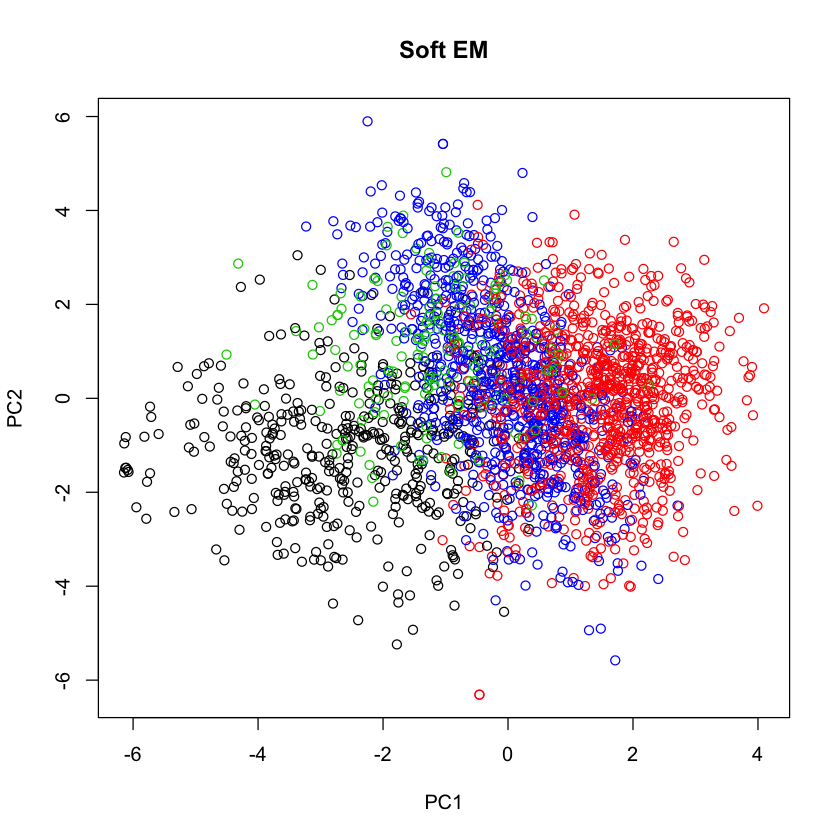

In [12]:
cluster.viz(t(count.scaled), soft.labels, 'Soft EM')

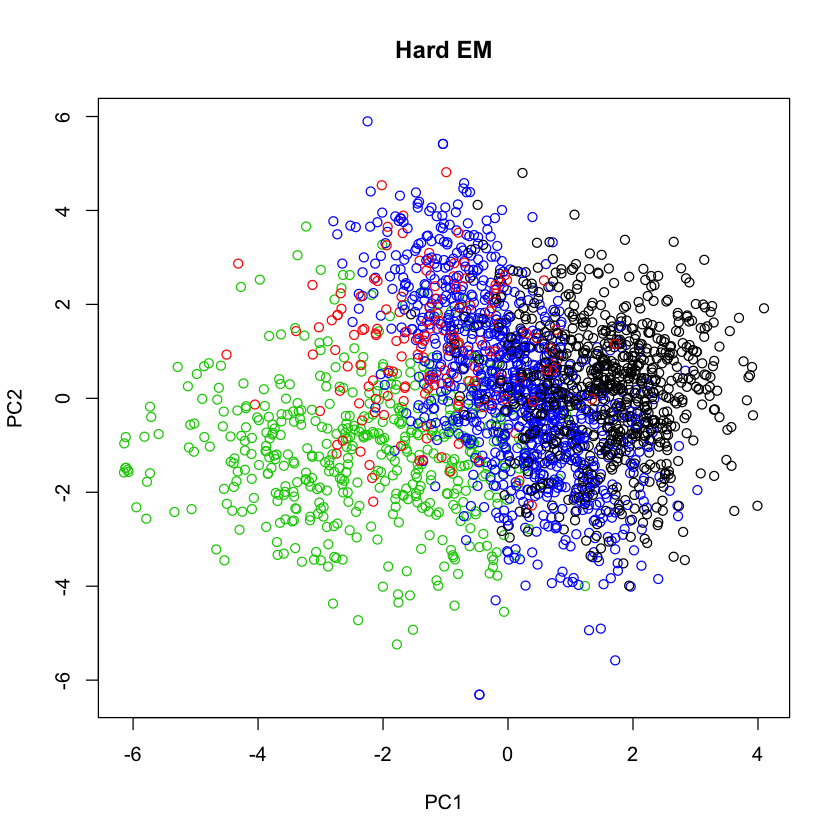

In [13]:
cluster.viz(t(count.scaled), hard.labels, 'Hard EM')

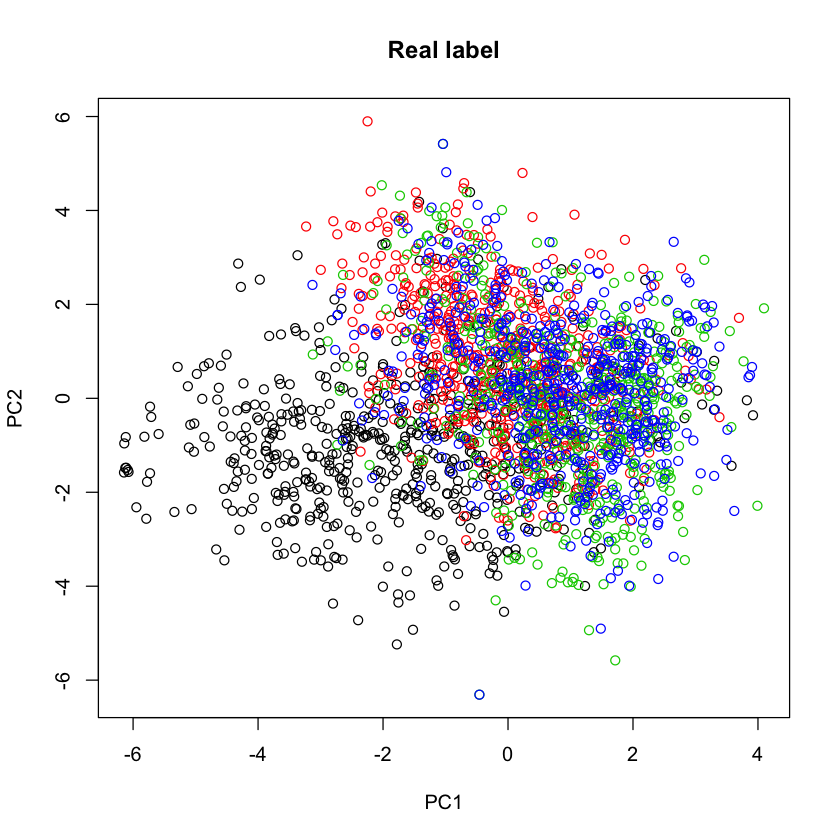

In [14]:
cluster.viz(t(count.scaled), factor(labels), 'Real label')